# Comparison of average rainfall in January between UBC and SFU

## Introduction

Intense rainfall is becoming more and more frequent as a result of climate change (Murdock et al., 2007), which is affecting many rainy districts such as MetroVancouver. UBC and SFU are both located in MetroVancouver, where winter is typically rainy. As January is ususally in the middle of winter, it can be considered as a typical winter month. According to Zhang et al., coastal and inland cities have different rainfall intensities (2022). Another research claims that total precipitation drops exponentially with distance from the sea for areas not covered by forests (Makarieva et al., 2009). Although these two universities are geographically close, SFU is further from the sea than UBC. Thus, our research question arises: Is there a significant difference between the average January rainfall of UBC and SFU?

Specifically, our random variable of interest is $\mu_1 - \mu_2$, where $\mu_1$ is the average January rainfall at UBC, and $\mu_2$ is the counterpart at SFU. The location parameter we choose is the mean, and we pick standard deviation as our scale parameter. The mean is chosen because it gives us a rough idea about which campus gets more rain. For example, if the mean is greater than 0, then it is likely that UBC has more rainfall than SFU. The standard deviation is chosen since it quantifies the spread of $\mu_1 - \mu_2$. If the standard deviation is large, then our variable varies much.

The two datasets we are going to use are loaded below. Each dataset contains monthly climate data collected at either UBC (Government of Canada, 1995) or SFU (Government of Canada, 2007). Note that we only have access to limited historical data, which can be considered as a sample from the population. Since the climate didn't change dramatically in a short period of time, this historical data is still representative and can be used for inferential purposes.

## Methods and Results

In the following section, we will explain the methods we used and why we chose to use them in our particular analysis case, as well as the results we obtained through the application of such methods and what they mean practically.

***

### Methods

#### Part 1: Preliminary Analysis
The first part of this project is concerned with data reading, wrangling and standardizing as well as a preliminary analysis, whose intent is to provide an understanding of the data we will use before we actually start an inferential analysis using methods like Confidence Intervals and Hypothesis Testing.

In order to conduct this preliminary analysis, we first read the data, which is hosted as a csv file. After reading the initial raw data, we wrangle it through column filtering, selection and renaming in order to produce a cleaner version, which is now ready for the analysis itself.

The first step of the actual analysis consists of the summarization of the summarization of the sample statistics we will use throughout the project. We denote these statistics by their name followed by the locality (UBC or SFU), so the mean of total rain at UBC would be denoted as `mean_UBC`, for instance. After we obtained each individual sample statistic, we then stored all of them in a tibble called `summary`.

The last step of our preliminary analysis is composed of data visualizations, which provides a helpful visual overview of the data we will be dealing with during the inferential analysis. The first graph we plotted is a boxplot, and through this visualization can extract information about the median of rainfall at each location, as well as the range of the variable, something that becomes helpful when formulating our hypothesis later on. The other graph we plot is a histogram of the rainfall, facetted horizontally by the locality, which helps us determine the shape of the distribution as well as relate the spread of the data with their frequency, something the boxplot fails to achieve. 

After we are done with these procedures and have identified key aspects of the data, we are ready to move to the next step, the actual Inferential Analysis.

#### Part 2: Inferential Analysis

Our inferential analysis utilizes several methods in order to conduct a precise study of our data and realiably analyze the data we are interested in. Notably, two methods along with their variations were used: Confidence Intervals (by bootstrapping with percentiles and standard error and by using the asymptotics method with the Central Limit Theorem) and Hypothesis Testing (by computer simulation and theoretical formula).

1. **Method 1: Confidence Intervals**

When applying Confidence Intervals to our data, we decided to use three different iterations of the same method using different approaches, the first two of which use a very similar strategy: first, we take 5000 boostrap samples, calculating the difference in means between rainfall at UBC and SFU. Next, we obtain the confidence interval of the boostrap distribution using a 95% confidence level, which means that across 100 samples of this same population, 95 will contain the true difference in means. The next step is where the percentile method differs from the standard error one, but in essence, what we do is calculate the lower and upper bounds of the confidence intervals by either stating the percentiles referring to them or their $Z-Score$ according to the standard error in the bootstrap distribution (in this case, since we are using a 95% CL, we would have $Z = 1.96$). Our last iteration uses the Asymptotic Method, basing itself on the Central Limit Theorem. We apply this by using the formula for the Confidence Interval in a t-distribution with to our sampled data, using the standard error as an approximation for the actual standard deviation. In order to find the number of degrees of freedom for our t-distribution, we found the minimum between the sample sample size of each station (UBC and SFU) minus 1. 

After each of these iterations was done, we plot histograms with shaded areas in order to denote our confidence interval, and by doing so, readily notice that although each method takes a different approach, the iterations actually come close to a similar result, something that was already expected but will be further discusses in the Discussion and Results section. 

2. **Method 2: Hypothesis Testing**

For our second method, we decided to use Hypothesis testing using two approaches, computer simulation and theoretical formula. For the first approach, we also start by resampling our original sample with permutation. Then, we calculate the observed difference in means between each station, and plot a histogram using the sampling distribution and the observed value in order to observe the distribution of values relative to the observed statistic. Following that, we obtain the p-value. 

In our second approach to hypothesis testing, we use theory in order to determine our test statistic and distribution (by calculating the degrees of freedom). By applying the formulas to the previously determined sample statistic we are able to finally obtain the p-value through the theoretical approach. 

***

### Results

The results we obtained through the application of the aforementioned methods were compatible with the initial conjecture that there is a difference between the mean Total Rain by millimeters at UBC and SFU grounds. 

This is first confirmed by the result obtained by our testing using confidence intervals, which consistently denoted that there is a negative difference the mean total rain at UBC and SFU in all approaches we considered (at a 95% confidence level). In other words, according to the results we obtained, 95% of all possible confidence intervals for this sample contain the true value, enclosed in the following bounds according to the approach:
- Percentile approach: [-122.058 , -35.054]
- Standard error approach: [-120.988, - 34.004]
- Asymptotics Method by CLT approach: [-122.836, -32.156]

Using the Hypothesis Testing method, the results were similar. Considering the null hypothesis $H_0: \mu_1 - \mu_2 = d_0$ and alternative hypothesis $H_1: \mu_1 - \mu_2 \neq d_0$ (given that $d_0 = 0$), at a 5% significance level ($ \alpha = 0.05$) we obtained the following p-values in our two different approaches:

- P-value obtained through computer simulation: $p = 0.0008$ <br>
- P-value obtained through theoretical approach: $p = 0.000989$

Hence, we are able to reject the null hypothesis at the established significance level, corroborating that there might in fact be a difference in the mean Total Rain (mm) between UBC and SFU.

## Part I: Preliminary Results

In [48]:
library(tidyverse)
library(repr)
library(datateachr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)

#### 1. Read the data

In [49]:
#first we read the original datasets
UBC <- read_csv("https://raw.githubusercontent.com/jessie-liang/STAT-201/main/en_climate_monthly_BC_1108487_1957-1995_P1M.csv") 
SFU <- read_csv("https://raw.githubusercontent.com/jessie-liang/STAT-201/main/en_climate_monthly_BC_1101158_1965-2007_P1M.csv") 
head(UBC)
head(SFU)

Rows: 462 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Station Name, Date/Time, Month, Mean Max Temp Flag, Mean Min Temp ...
dbl (13): Longitude (x), Latitude (y), Climate ID, Year, Mean Max Temp (°C),...
lgl  (4): Dir of Max Gust (10's deg), Dir of Max Gust Flag, Spd of Max Gust ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 506 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Station Name, Date/Time, Month, Mean Max Temp Flag, Mean Min Temp ...
dbl (13): Longitude (x), Latitude (y), Climate ID, Year, Mean Max Temp (°C),...
lgl  (4): Dir of Max Gust (10's deg), Dir of Max Gust Flag, Spd of Max Gust ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALS

Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Mean Max Temp (°C),Mean Max Temp Flag,Mean Min Temp (°C),⋯,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow Grnd Last Day (cm),Snow Grnd Last Day Flag,Dir of Max Gust (10's deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
-123.25,49.25,VANCOUVER UBC,1108487,1957-01,1957,01,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-02,1957,02,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-03,1957,03,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-04,1957,04,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-05,1957,05,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-06,1957,06,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA


Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Mean Max Temp (°C),Mean Max Temp Flag,Mean Min Temp (°C),⋯,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow Grnd Last Day (cm),Snow Grnd Last Day Flag,Dir of Max Gust (10's deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-01,1965,01,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-02,1965,02,5.0,NA,0.8,⋯,14.5,NA,363.2,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-03,1965,03,9.4,NA,2.5,⋯,7.1,NA,65.8,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-04,1965,04,11.4,NA,5.1,⋯,0.0,T,89.9,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-05,1965,05,13.5,NA,6.4,⋯,0.0,T,94.2,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-06,1965,06,18.8,NA,10.4,⋯,0.0,NA,13.5,NA,0,NA,NA,NA,NA,NA


#### 2. Wrangle data into tidy format

In [50]:
#then, we wrangle the data to get a tidy dataset

UBC_SFU_January <- rbind(UBC, SFU) %>%
                    filter(Month == "01") %>%
                    select('Station Name', Year, Month, 'Total Rain (mm)' ) %>%
                    rename(Station = 'Station Name', Rainfall = 'Total Rain (mm)') %>%
                    filter(!is.na(Rainfall)) 

head(UBC_SFU_January)
tail(UBC_SFU_January)
nrow(UBC_SFU_January)

Station,Year,Month,Rainfall
<chr>,<dbl>,<chr>,<dbl>
VANCOUVER UBC,1958,01,298.5
VANCOUVER UBC,1959,01,158.2
VANCOUVER UBC,1960,01,161.5
VANCOUVER UBC,1961,01,236.0
VANCOUVER UBC,1962,01,140.5
VANCOUVER UBC,1963,01,18.3


Station,Year,Month,Rainfall
<chr>,<dbl>,<chr>,<dbl>
BURNABY SIMON FRASER U,2002,01,151.4
BURNABY SIMON FRASER U,2003,01,239.4
BURNABY SIMON FRASER U,2004,01,235.2
BURNABY SIMON FRASER U,2005,01,360.4
BURNABY SIMON FRASER U,2006,01,458.4
BURNABY SIMON FRASER U,2007,01,367.6


[1] 75

#### 3. Sample Statistic Summary

In [51]:
# Calculate sample statistics and create summary tibble containing data

n_UBC <- UBC_SFU_January %>%
        filter(Station == "VANCOUVER UBC") %>%
        summarize(n_1 = n()) %>%
        pull()

n_SFU <- UBC_SFU_January %>%
        filter(Station == "BURNABY SIMON FRASER U") %>%
        summarize(n_2 = n()) %>%
        pull()

mu1 <- UBC_SFU_January %>%
        filter(Station == "VANCOUVER UBC") %>%
        summarize(mean1 = mean(Rainfall)) %>%
        pull()

mu2 <- UBC_SFU_January %>%
        filter(Station == "BURNABY SIMON FRASER U") %>%
        summarize(mean2 = mean(Rainfall)) %>%
        pull()

var_UBC <- UBC_SFU_January %>%
        filter(Station == "VANCOUVER UBC") %>%
        summarize(var_1 = var(Rainfall)) %>%
        pull()

var_SFU <- UBC_SFU_January %>%
        filter(Station == "BURNABY SIMON FRASER U") %>%
        summarize(var_2 = var(Rainfall)) %>%
        pull()

sample_statistic <- mu1 - mu2

sd_of_sampling_dist <- sqrt(var_UBC/n_UBC + var_SFU/n_SFU)
            
summary <- tibble(n_UBC = n_UBC,
                 n_SFU = n_SFU,
                 mean_UBC = mu1,
                 mean_SFU = mu2,
                 var_UBC = var_UBC,
                 var_SFU = var_SFU,
                 sample_statistic = sample_statistic,
                 sd_of_sampling_dist = sd_of_sampling_dist)

summary

n_UBC,n_SFU,mean_UBC,mean_SFU,var_UBC,var_SFU,sample_statistic,sd_of_sampling_dist
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
38,37,155.0658,232.5622,5021.174,13603.2,-77.49637,22.35599


#### 4. Plot raw data

##### Figure 1 - Boxplot comparison between Rainfall at UBC and SFU

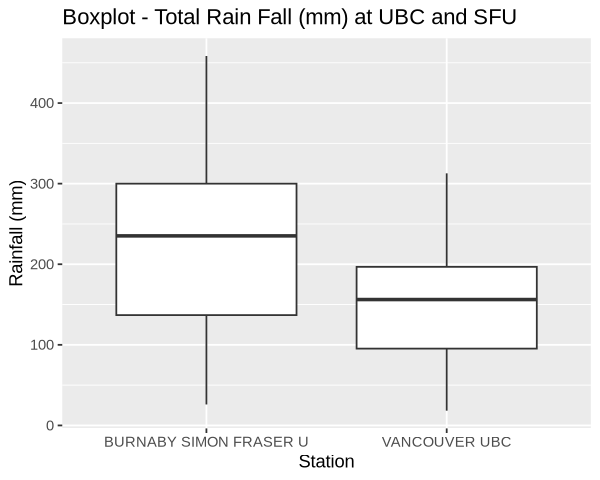

In [52]:
#boxplot
boxplot <- UBC_SFU_January %>%
            ggplot(aes(Station, Rainfall)) +
            geom_boxplot() + 
            ggtitle("Boxplot - Total Rain Fall (mm) at UBC and SFU") +
            ylab("Rainfall (mm)")
options(repr.plot.width = 5, repr.plot.height =4) 

boxplot

##### Figure 2 - Histogram comparion between Rainfall at UBC and SFU

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


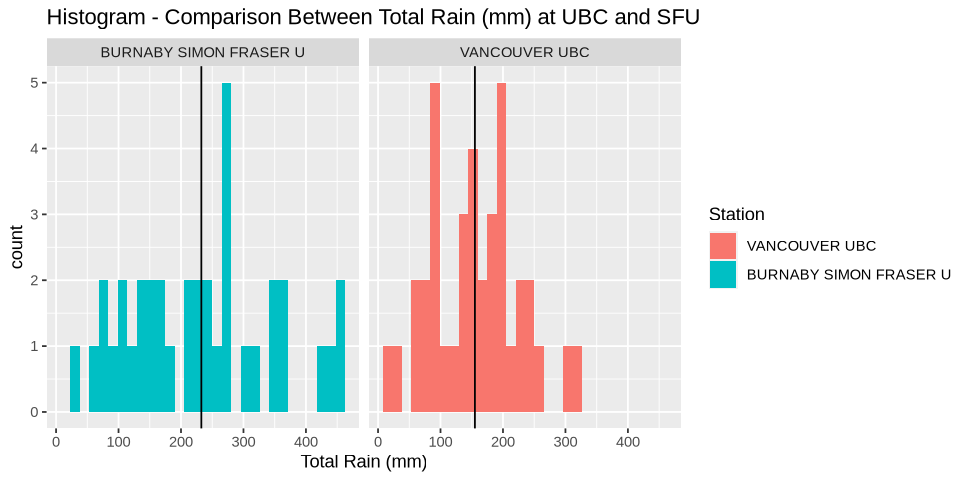

In [53]:
#side-by-side histogram

sample_dist <- UBC_SFU_January %>%
    group_by(Station) %>%
    mutate(mean = mean(Rainfall)) %>%
    ungroup %>%
    ggplot(aes(x = Rainfall, fill = as_factor(Station)))+
    geom_histogram()+
    geom_vline(aes(xintercept = mean), color="black")+
    facet_wrap(~Station) +
    ggtitle("Histogram - Comparison Between Total Rain (mm) at UBC and SFU") +
    xlab("Total Rain (mm)") +
    labs(fill = "Station")
    

options(repr.plot.width = 8, repr.plot.height =4) 
sample_dist

## Part II: Inferential Analysis and Results

### 1. Confidence Intervals

#### Method 1: Bootstrapping with Percentile Method

In [54]:
set.seed(2023)
bootstrap_dist <- UBC_SFU_January %>%
        specify(formula = Rainfall ~ Station) %>%
        generate(reps = 5000, type = "bootstrap") %>%
        calculate(stat = "diff in means", order=c("VANCOUVER UBC", "BURNABY SIMON FRASER U")) 
head(bootstrap_dist)

replicate,stat
<int>,<dbl>
1,-80.82006
2,-84.36752
3,-84.65406
4,-68.23717
5,-114.29892
6,-74.12783


In [55]:
percentile_ci <- bootstrap_dist %>% 
  get_confidence_interval(level = 0.95, type = "percentile")
percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
-122.0585,-35.05488


##### Figure 3 - Bootstrap Distribution with Confidence Intervals (Percentile Method)

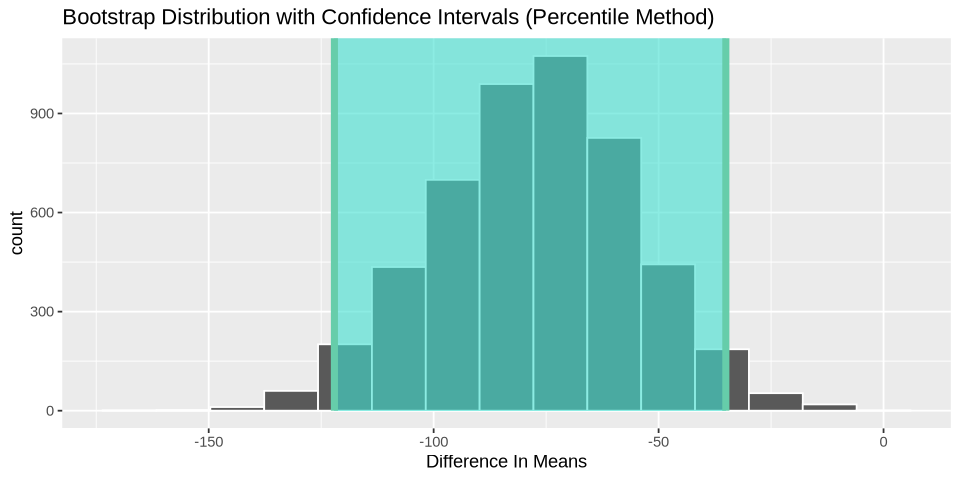

In [56]:
visualize(bootstrap_dist) + 
    shade_confidence_interval(endpoints = percentile_ci) + 
    labs(x = "Difference In Means", title = "Bootstrap Distribution with Confidence Intervals (Percentile Method)")

***

#### Method 2: Bootstrapping with Standard Error Method

##### Figure 4 - Bootstrap Distribution of Difference in Means of Total Rainfall

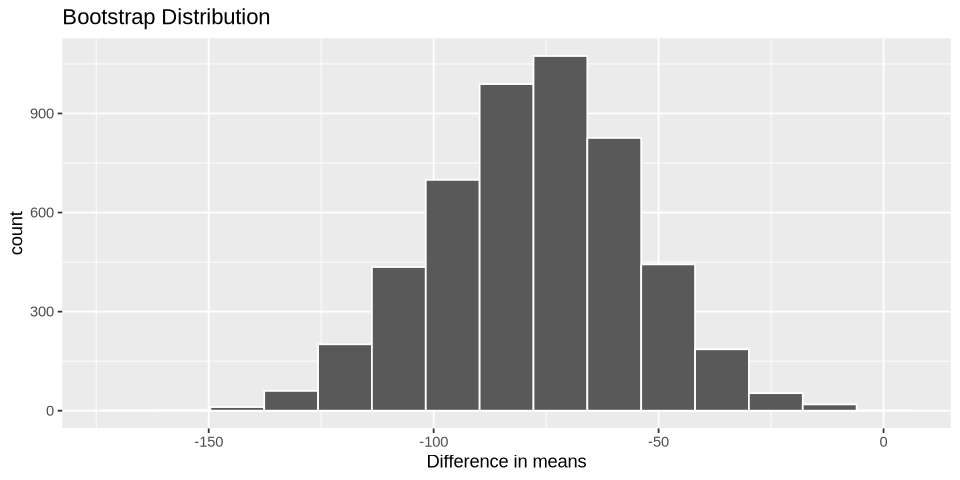

In [57]:
#first we check whether the bootstrap distribution is normally shaped

bootstrap_dist %>% visualize() +
        labs(x = "Difference in means", title = "Bootstrap Distribution")

In [58]:
standard_error_ci <- bootstrap_dist %>% 
  get_confidence_interval(type = "se", level = 0.95, point_estimate = sample_statistic)
standard_error_ci

lower_ci,upper_ci
<dbl>,<dbl>
-120.988,-34.00478


##### Figure 5 - Bootstrap Distribution with Confidence Intervals (Standard Error Method)

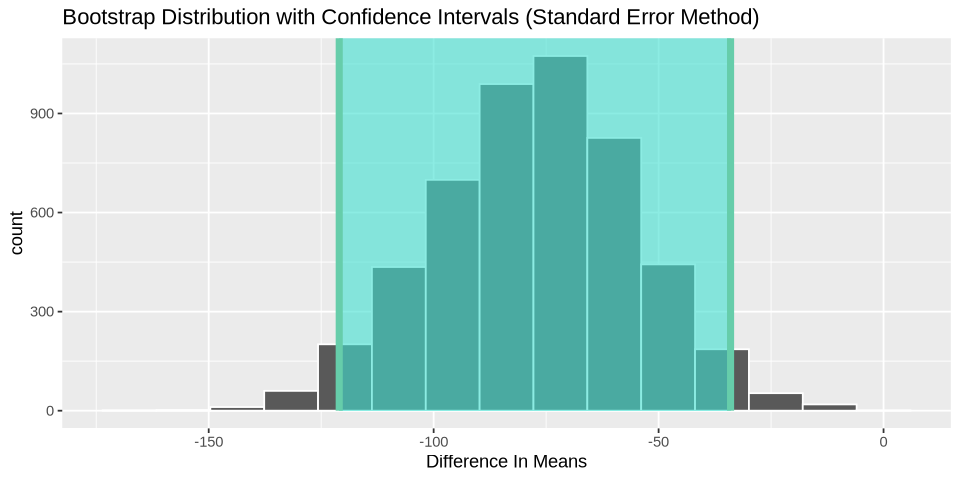

In [59]:
visualize(bootstrap_dist) + 
    shade_confidence_interval(endpoints = standard_error_ci) +
    labs(x = "Difference In Means", title = "Bootstrap Distribution with Confidence Intervals (Standard Error Method)")

***

#### Method 3: Asymptotics methods by CLT

We use the following formula:

$$CI(\mu_1 - \mu_2) = (\overline{X_1} - \overline{X_2}) \pm t^\ast \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$

Here, the t-distribution has degree of freedom $min(n_1-1, n_2-1)$ approximately. (Yu, n.d.)

In [60]:
df <- min(n_UBC-1, n_SFU-1)
CLT_ci <- 
     tibble(
         lower_ci = mu1 - mu2 - qt(0.975, df) * sqrt(var_UBC/n_UBC + var_SFU/n_SFU),
         upper_ci = mu1 - mu2 + qt(0.975, df) * sqrt(var_UBC/n_UBC + var_SFU/n_SFU)
     )
CLT_ci

lower_ci,upper_ci
<dbl>,<dbl>
-122.8364,-32.15633


##### Figure 6 - Bootstrap Distribution with Confidence Intervals (Asymptotics by CLT Method)

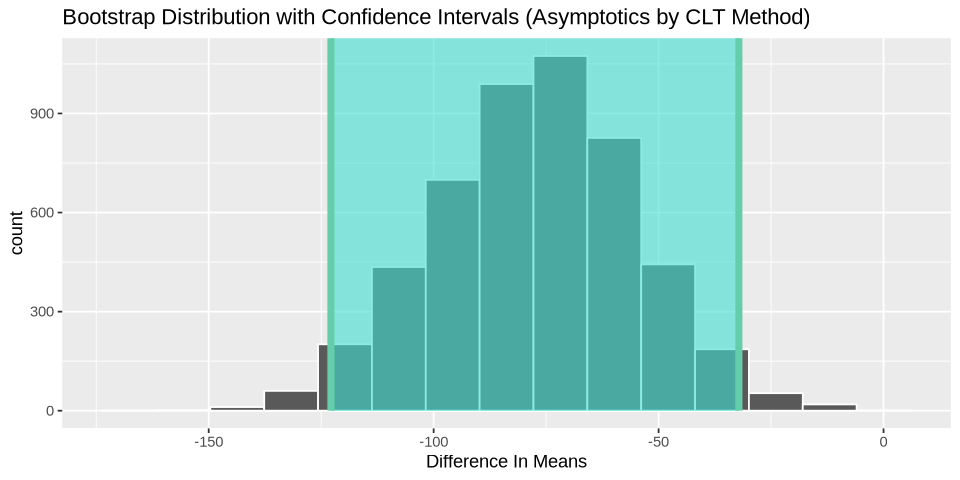

In [61]:
visualize(bootstrap_dist) + 
    shade_confidence_interval(endpoints = CLT_ci) + 
    labs(x = "Difference In Means", title = "Bootstrap Distribution with Confidence Intervals (Asymptotics by CLT Method)")

***

### 2. Hypothesis Testing

#### Method 1: by computer simulation

To perform computer-simulated hypothesis testing, we use a modified version of infer workflow. This includes five major parts, namely specify, hypothesize, generate, calculate and visualize.

In [62]:
set.seed(2023)
rainfall_generate <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 5000, type = "permute")

nrow(rainfall_generate)

[1] 375000

For this dataset, the workflow is as follows-
1. **specify**
We use formula = response ~ explanatory where Rainfall is the response variable for our dataset and Station is the explanatory variable.
2. **hypothesize**
As our dataset involved two samples(UBC & SFU), we set null = "independence".
3. **generate**
This is done to generate replicates of “shuffled” datasets assuming the null hypothesis is true. Here, we set type = "permute", because permutations are a kind of resampling that involve resampling without replacement.
4. **calculate**
Now we calculate the test-statistic for the 5000 shuffles generated in the previous step by setting stat = "diff in means".
5. **visualize**
We visualize the null_distribution next, also we use the shade_p_value() function with obs_stat and set the direction = "both" reflecting our alternative hypothesis.

In [63]:
set.seed(2023)
null_distribution <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 5000, type = "permute") %>% 
  calculate(stat = "diff in means", order = c("VANCOUVER UBC", "BURNABY SIMON FRASER U"))
head(null_distribution)

replicate,stat
<int>,<dbl>
1,-28.458321
2,0.528165
3,15.554836
4,1.824395
5,16.173613
6,44.173257


In [64]:
obs_diff_means <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  calculate(stat = "diff in means", order = c("VANCOUVER UBC", "BURNABY SIMON FRASER U"))
obs_diff_means

stat
<dbl>
-77.49637


##### Figure 7 - Histogram with Permutation Test for Difference in Means

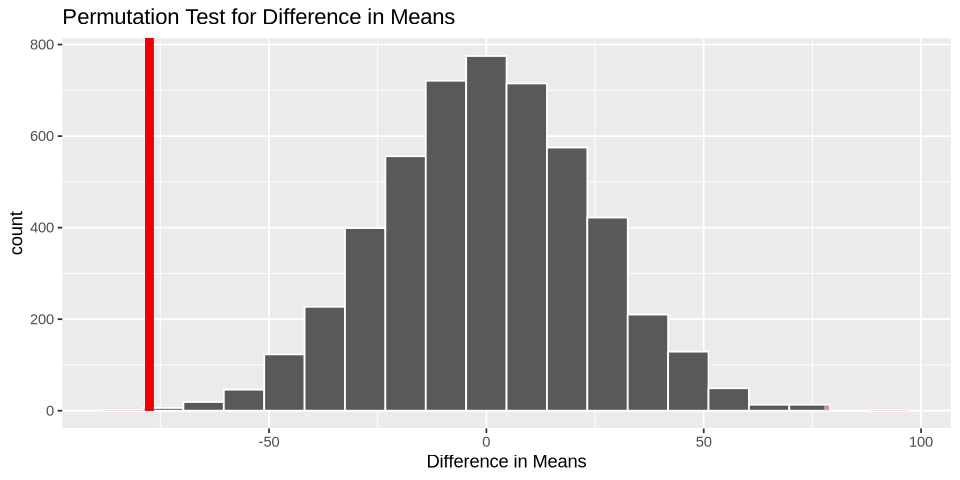

In [65]:
visualize(null_distribution, bins = 20) + 
  shade_p_value(obs_stat = obs_diff_means, direction = "both")+
  labs(title = "Permutation Test for Difference in Means", x = "Difference in Means")

In [66]:
null_distribution %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")

p_value
<dbl>
8e-04


#### Method 2: by theoretical formula

When researchers didn’t have access to computers that could run thousands of calculations quickly and efficiently, the traditional theory-based methods were used. With easy and cheap access to computer power, traditional theory-based method is not the only approach anymore. However, it is still used by researchers in many fields. Thus, we choose to include this method here.

Here, we are focusing on the two-sample t-test for testing differences in sample means.

The null hypothesis and the alternative hypothesis are the following:

$$H_0: \mu_1 - \mu_2 = d_0$$

$$H_1: \mu_1 - \mu_2 \neq d_0$$

Note that $d_0 = 0$

We use the following formula to calculate t-statistic:

$$t = \frac {(\overline{x_1} - \overline{x_2})- d_0} {\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

Since $d_0 = 0$, our test statistic simplifies a bit:

$$t = \frac {(\overline{x_1} - \overline{x_2})} {\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

The null distribution of our test statistic is a t-distribution with the following degree of freedom:
$$
\nu = \frac{
    \left(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}\right)^2
}
{
\frac{s_1^4}{n_1^2(n_1-1)}+\frac{s_2^4}{n_2^2(n_2-1)}
}
$$

In [67]:
#test statistic
T <- (mu1 - mu2)/sqrt(var_UBC/n_UBC + var_SFU/n_SFU)

#degree of freedom
df <- (var_UBC/n_UBC + var_SFU/n_SFU)^2/(((var_UBC)^2/((n_UBC)^2*(n_UBC - 1))) + ((var_SFU)^2/((n_SFU)^2*(n_SFU - 1))))

#p-value
p <- 2*pt(-abs(T), df)
p

[1] 0.0009890616

Since the population distribution is unknown, we have to rely on CLT here. So, the following four conditions must be met:

* The sample is selected randomly from the population. (Since we collect data in a random way, this requirement is satisfied.)
* Large sample size. A general rule of thumb that works in many (but not all) situations is that the sample size n should be greater than 30. (As n_UBC = 38 and n_SFU = 37, this condition is satisfied.)
* Both samples are selected independently of each other. (As we're extracting data for UBC and SFU independently,the observations in one sample are not influenced by the observations in the other sample.)
* All observations are independent from each other. (The sample size is less than or equal to 10% of the population size. Thus, the condition is also satisfied.)

### Discussion

#### 1. Summary of our result

#### 2. Implications/impacts of our findings

As for the impacts, our report can help both universities consider how to keep campuses safe during the rainy season. Also, our report can provide information from a climate perspective for high school students who are choosing which university to apply.

#### 3. Result vs Our expectation

#### 4. Further questions

Our report may lead to future questions such as: Why is the rainfall different between UBC and SFU? How will the rainfall change in the future in these two universities? What is the pattern of rainfall in other seasons between UBC and SFU?

### References

Government of Canada. (2007). en_climate_monthly_BC_1101158_1965-2007_P1M [Dataset]. https://climate.weather.gc.ca/climate_data/monthly_data_e.html?hlyRange=%7C&dlyRange=1965-02-01%7C2022-06-04&mlyRange=1965-01-01%7C2007-02-01&StationID=731&Prov=BC&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2023&selRowPerPage=25&Line=0&searchMethod=contains&Month=10&Day=27&txtStationName=Simon+Fraser&timeframe=3&Year=2007

Government of Canada. (1995). en_climate_monthly_BC_1108487_1957-1995_P1M [Dataset]. https://climate.weather.gc.ca/climate_data/monthly_data_e.html?hlyRange=%7C&dlyRange=1957-09-01%7C1995-06-30&mlyRange=1957-01-01%7C1995-06-01&StationID=903&Prov=BC&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2023&selRowPerPage=25&Line=6&searchMethod=contains&Month=6&Day=27&txtStationName=UBC&timeframe=3&Year=1995

Makarieva, A. M., Gorshkov, V. G., & Li, B.-L. (2009). Precipitation on land versus distance from the ocean: Evidence for a forest pump of atmospheric moisture. Ecological Complexity, 6(3), 302–307. https://doi.org/10.1016/j.ecocom.2008.11.004
‌

Trevor Q. Murdock, Katrina E. Bennett, & Arelia T. Werner. (2007). GVRD Historical and Future Rainfall Analysis Update.

Yu, Eugenia (n.d.). Comparing Means between Two Independent Groups [PowerPoint slides]. Department of Statistics, University of British Columbia. https://canvas.ubc.ca/courses/126179/files/27859553?module_item_id=5901773

Zhang, W., Yang, J., Yang, L., & Niyogi, D. (2022). Impacts of City Shape on Rainfall in Inland and Coastal Environments. Earth’s Future, 10(5). https://doi.org/10.1029/2022ef002654